In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import pickle


mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = True # false originally

In [0]:
# %%timeit
# load data located ashrae_data into dataframes 
train_csv_path = '/content/drive/My Drive/ashrae_data/train.csv'
weather_train_csv_path = '/content/drive/My Drive/ashrae_data/weather_train.csv'
test_csv_path = '/content/drive/My Drive/ashrae_data/test.csv'
building_metadata_csv_path = '/content/drive/My Drive/ashrae_data/building_metadata.csv' 
primary_usage_translations_csv_path = '/content/drive/My Drive/ashrae_data/primary_usage_translations.csv' 

train_df = pd.read_csv(train_csv_path) #, nrows = 1000000)
weather_train_df = pd.read_csv(weather_train_csv_path) #, nrows = 1000000)
# test_df = pd.read_csv(test_csv_path) #, nrows = 1000000)
building_metadata_df = pd.read_csv(building_metadata_csv_path) #, nrows = 1000000)
primary_usage_translations_df = pd.read_csv(primary_usage_translations_csv_path)

## Visualizing a sample
To get a feel for the data, let's have a look at a few example meter readings from a random building.
We pick a sample of size 120 to get energy consumptions for a five day timeframe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc971e53d30>],
      dtype=object)

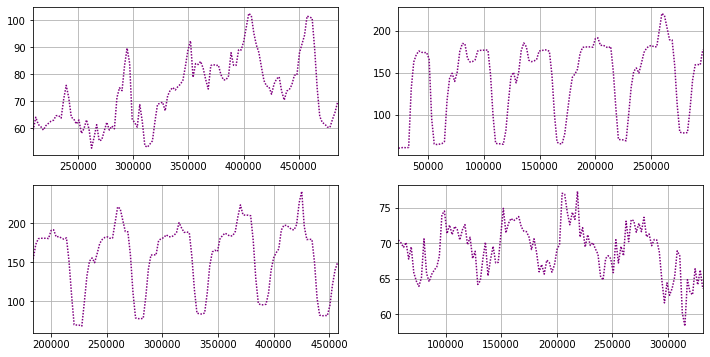

In [436]:
# get random variables that will be used to collect the data...
sample_building_ids = [np.random.randint(200,210) for i in range(4)]
sample_starts = [np.random.randint(0,100) for i in range(4)]

# collect samples
sample1 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[0]].loc[train_df.meter == 0][sample_starts[0]:sample_starts[0] + 120]
sample2 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[1]].loc[train_df.meter == 0][sample_starts[1]:sample_starts[1] + 120]
sample3 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[2]].loc[train_df.meter == 0][sample_starts[2]:sample_starts[2] + 120]
sample4 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[3]].loc[train_df.meter == 0][sample_starts[3]:sample_starts[3] + 120]

# init figure
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,6))
# plot the samples
sample1.plot(ax = axes[0][0],subplots=True, linestyle = (0, (1,1)), color = 'purple')
sample2.plot(ax = axes[0][1],subplots=True, linestyle = (0, (1,1)), color = 'purple')
sample3.plot(ax = axes[1][0],subplots=True, linestyle = (0, (1,1)), color = 'purple')
sample4.plot(ax = axes[1][1],subplots=True, linestyle = (0, (1,1)), color = 'purple')

In [333]:
def convert_timestamp(timestamp):
    return int(timestamp[5:14].replace(' ','').replace('-','').replace(':',''))


def get_sample(building_id, meter, start, size, split):
    """
    data:
                    site    building_id     meter   meter_reading   air_temp    cloud_coverage  wind_speed  wind_direction  ...
    time start
    time start+1
    ...
    time split

    labels:
                    meter_reading
    time split+1
    time split+2
    ....
    time start+size
    """
    # get site_id of building
    site_id = building_metadata_df['site_id'].loc[building_metadata_df['building_id']==building_id].values[0]

    # get train and weather data in relevant time window
    t = train_df[['timestamp', 'meter','meter_reading']].loc[train_df['building_id']==building_id][start:start+size]
    w = weather_train_df[['timestamp','air_temperature','cloud_coverage','precip_depth_1_hr','wind_speed']].loc[weather_train_df['site_id']==site_id][start:start+size] # TRY maybe remove timestamp to avoid merge problems
    t.set_index('timestamp')
    w.set_index('timestamp')

    sample_merged = pd.merge(t, w, on=['timestamp']) # merge the two
    sample_merged.timestamp = sample_merged.timestamp.apply(convert_timestamp) # make timestamp numeric
    
    # TODO standardize data
    # print(sample_merged['meter_reading'].std())
    
    sample_merged = (sample_merged - sample_merged.mean()) / sample_merged.std()
    sample_merged = sample_merged.fillna(0) # TODO find out whether this is actually okay...

    sample_merged['site_id'] = [site_id for x in range(sample_merged.shape[0])] # add site_id as column
    # print(sample_merged)
    # split into data and labels
    data = sample_merged[:split] 
    labels = sample_merged['meter_reading'][split:]

    # return as numpy array
    return data.to_numpy(), labels.to_numpy()



def pick_samples(num_buildings = 1, start_range = (0,10), offset = 0):
    """ Use get_sample to build a training data set. """
    all_data, all_labels = [],[]
    building_ids = train_df.building_id.unique()
    # print(building_ids)
    c = 0
    for id in building_ids[offset:offset+num_buildings]:
        for start in range(start_range[0], start_range[1], 10):
            # print(start)
            for meter in train_df.meter.unique():
            # for meter in [0]:
                c += 1
                # print(meter)
                data, labels = get_sample(id, meter, start, 5*24,4*24) # TODO pass this as parameter
                all_data.append(data)
                all_labels.append(labels)
                if c%100 == 0:
                    print("sample {} of {}...".format(c, num_buildings * 4 * ((start_range[1]-start_range[0]) / 10)))

    return all_data, all_labels



x_train,y_train = pick_samples(10, start_range = (0,100), offset=200)
x_val,y_val = pick_samples(2, start_range= (0,100), offset = 210)




# test_x, test_y = pick_samples(10, start_range = (0,100), offset=100)


sample 100 of 400.0...
sample 200 of 400.0...
sample 300 of 400.0...
sample 400 of 400.0...


## Cleaning the Data
Sometimes there aren't 24 values for a label, so we need to remove those rows. This way we will avoid problems down below.


In [0]:
def remove_broken_samples(data, labels, output_shape = 24):
    clean_data, clean_labels = [], []

    for i, label in enumerate(labels):
        if label.shape[0] == output_shape:
            clean_data.append(data[i])
            clean_labels.append(labels[i])
    return clean_data, clean_labels



x_train,y_train = remove_broken_samples(x_train, y_train)
x_val,y_val = remove_broken_samples(x_val, y_val)
# print(len(test_y))

# new_x, new_y = remove_broken_samples(test_x, test_y)
# print(len(new_x))

# dummy_data = tf.data.Dataset.from_tensor_slices((new_test_x,new_test_y))
# dummy_data = val_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

## Store the training data
To avoid sampling the data all over again each time we store it in a pickle file. This will allow us to load it much faster the next time.

In [0]:
# !ls drive/My\ Drive/ashrae_data

def pickle_data(filename, data):
    with open('/content/drive/My Drive/ashrae_data/' + filename, 'wb') as f:
        pickle.dump(data,f)


pickle_data('train_samples_x.pkl', x_train)
pickle_data('train_samples_y.pkl', y_train)
pickle_data('val_samples_x.pkl', x_val)
pickle_data('val_samples_y.pkl', y_val)

## Load the pickled data
Let's load the data from the pickle files!

In [0]:
with open('/content/drive/My Drive/ashrae_data/' + 'train_samples_x.pkl', 'rb') as f:
    x_train = pickle.load(f)

with open('/content/drive/My Drive/ashrae_data/' + 'train_samples_y.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('/content/drive/My Drive/ashrae_data/' + 'val_samples_x.pkl', 'rb') as f:
    x_val = pickle.load(f)

with open('/content/drive/My Drive/ashrae_data/' + 'val_samples_y.pkl', 'rb') as f:
    y_val = pickle.load(f)

In [180]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)



(24,)


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data = val_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()



## Defining the Model
After collecting and preparing all the data we create a model...

In [0]:
# print(x_train[0].shape[-2:])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(
    32,
    return_sequences = True,
    input_shape=x_train[0].shape
))
model.add(tf.keras.layers.LSTM(16,activation='relu')) # was relu
model.add(tf.keras.layers.Dense(24))

model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),loss='mae')



In [337]:
EVALUATION_INTERVAL = 100
EPOCHS = 50


history = model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50
                    )


Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 10s 98ms/step - loss: 0.8493 - val_loss: 0.7645
Epoch 2/50
100/100 [==============================] - 6s 61ms/step - loss: 0.7057 - val_loss: 0.7004
Epoch 3/50
100/100 [==============================] - 6s 62ms/step - loss: 0.6132 - val_loss: 0.7379
Epoch 4/50
100/100 [==============================] - 6s 62ms/step - loss: 0.5181 - val_loss: 0.7706
Epoch 5/50
100/100 [==============================] - 6s 64ms/step - loss: 0.4397 - val_loss: 0.8796
Epoch 6/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3846 - val_loss: 0.8247
Epoch 7/50
100/100 [==============================] - 6s 64ms/step - loss: 0.3497 - val_loss: 0.7875
Epoch 8/50
100/100 [==============================] - 6s 65ms/step - loss: 0.3315 - val_loss: 0.7724
Epoch 9/50
100/100 [==============================] - 6s 62ms/step - loss: 0.3128 - val_loss: 0.7497
Epoch 10/50
100/100 [==========================

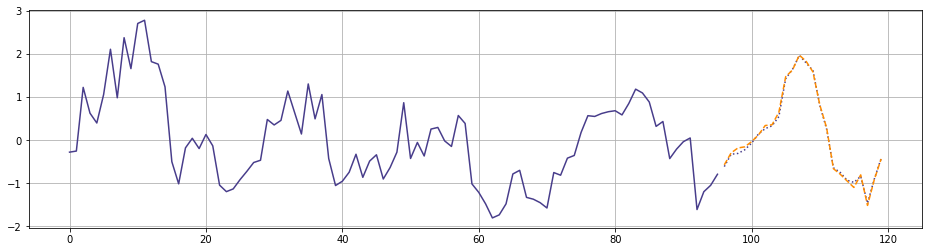

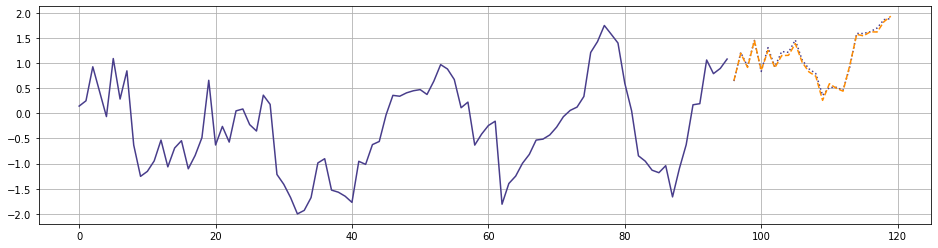

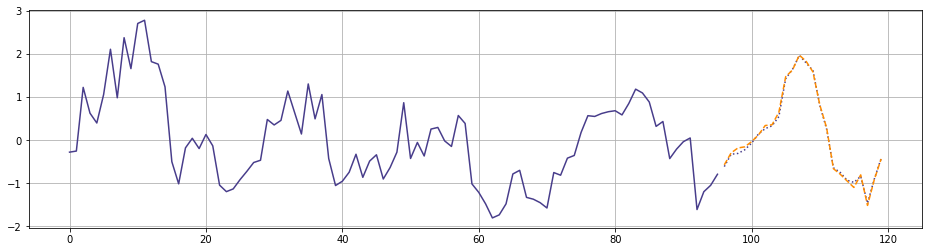

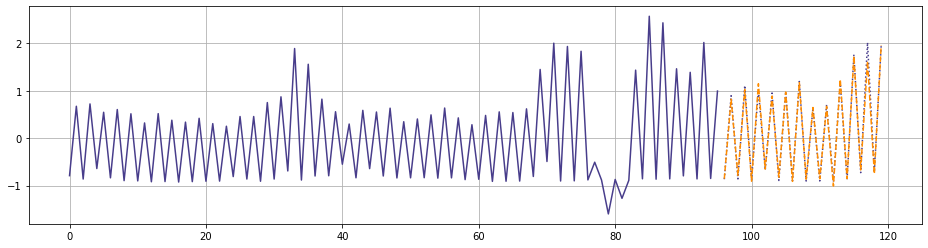

In [430]:
mpl.rcParams['figure.figsize'] = (16, 4)


# make prediction after training
for x, y in train_data.take(4):
    # each is mini batch of size 8
    r = 0#np.random.randint(0, BATCH_SIZE-1)
    # print(r)
    meter_readings_x = [i[2] for i in x[r]] # pick random sample from mini batch
    prediction = model.predict(x)[r]
    # print(len(meter_readings))
    # print(prediction.shape)



    plt.plot([x for x in range(96)], meter_readings_x, color = 'darkslateblue')
    plt.plot([x for x in range(96, 120)],y[r], color = 'darkslateblue', linestyle = 'dotted')#, linestyle = 'dashed')
    plt.plot([x for x in range(96, 120)], prediction, linestyle = 'dashed', color = 'darkorange')
    plt.show()


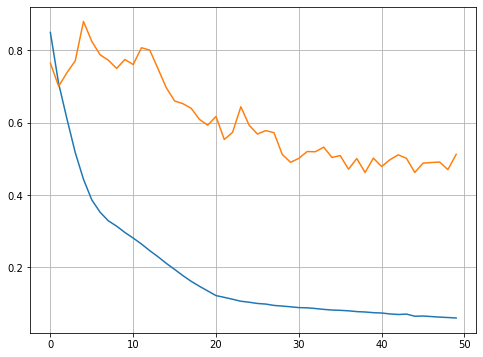

In [341]:
# print(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
